<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Michelle Avendaño
- Nombre de alumno 2: Claudia Navarro


### **Link de repositorio de GitHub:** `https://github.com/ClaudiaRayen/MDS7202-Laboratorios/tree/Lab10`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [ ]:
import numpy as np
import pandas as pd


# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except:
    print('Ignorando conexión drive-colab')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install shap

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import warnings
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix
import shap
import xgboost as xgb



In [ ]:
df = pd.read_csv('/content/diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

In [ ]:
!pip install xgboost

In [ ]:
non_numeric_columns = df.select_dtypes(['number']).columns
for column in non_numeric_columns:
    print(f"Conteo de valores en '{column}':")
    print(tabulate(df[column].value_counts().reset_index(), headers=['Valor', 'Conteo'], tablefmt='pretty'))

Conteo de valores en 'Age':
+----+-------+---------+
|    | Valor | Conteo  |
+----+-------+---------+
| 0  | 10.0  | 10856.0 |
| 1  |  9.0  | 10112.0 |
| 2  |  8.0  | 8603.0  |
| 3  | 11.0  | 8044.0  |
| 4  |  7.0  | 6872.0  |
| 5  | 13.0  | 5426.0  |
| 6  | 12.0  | 5394.0  |
| 7  |  6.0  | 4648.0  |
| 8  |  5.0  | 3520.0  |
| 9  |  4.0  | 2793.0  |
| 10 |  3.0  | 2049.0  |
| 11 |  2.0  | 1396.0  |
| 12 |  1.0  |  979.0  |
+----+-------+---------+
Conteo de valores en 'Sex':
+---+-------+---------+
|   | Valor | Conteo  |
+---+-------+---------+
| 0 |  0.0  | 38386.0 |
| 1 |  1.0  | 32306.0 |
+---+-------+---------+
Conteo de valores en 'HighChol':
+---+-------+---------+
|   | Valor | Conteo  |
+---+-------+---------+
| 0 |  1.0  | 37163.0 |
| 1 |  0.0  | 33529.0 |
+---+-------+---------+
Conteo de valores en 'CholCheck':
+---+-------+---------+
|   | Valor | Conteo  |
+---+-------+---------+
| 0 |  1.0  | 68943.0 |
| 1 |  0.0  | 1749.0  |
+---+-------+---------+
Conteo de valores en

In [ ]:
suma_nulos_por_columna = df.isnull().sum()
tabla_suma_nulos = pd.DataFrame(suma_nulos_por_columna, columns=['Suma de Valores Nulos'])
print(tabulate(tabla_suma_nulos, headers='keys', tablefmt='pretty'))

+----------------------+-----------------------+
|                      | Suma de Valores Nulos |
+----------------------+-----------------------+
|         Age          |           0           |
|         Sex          |           0           |
|       HighChol       |           0           |
|      CholCheck       |           0           |
|         BMI          |           0           |
|        Smoker        |           0           |
| HeartDiseaseorAttack |           0           |
|     PhysActivity     |           0           |
|        Fruits        |           0           |
|       Veggies        |           0           |
|  HvyAlcoholConsump   |           0           |
|       GenHlth        |           0           |
|       MentHlth       |           0           |
|       PhysHlth       |           0           |
|       DiffWalk       |           0           |
|        Stroke        |           0           |
|        HighBP        |           0           |
|       Diabetes    

In [ ]:
# Definir listas de características por tipo
numeric = ['Age', 'BMI']
ordinal = ['GenHlth', 'MentHlth', 'PhysHlth']
categoric = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump','DiffWalk', 'Stroke', 'HighBP']


# Definir el ColumnTransformer para manejar diferentes tipos de características
ct = ColumnTransformer(
    [
        ('One Hot', OneHotEncoder(sparse=False, handle_unknown="ignore", drop='if_binary'), categoric),  # Codificación One-Hot para variables categóricas
        ('Scaler', StandardScaler(), numeric) ,  # Escalado para variables numéricas
        ('Ordinal', OrdinalEncoder(), ordinal)  # Codificación ordinal para variables ordinales

    ],
    remainder='passthrough'  # Se pasan las características no especificadas sin transformaciones
)

# Crear un pipeline
XGBoost_clas = Pipeline(steps=[
    ("preprocessing", ct),  # Paso de preprocesamiento utilizando el ColumnTransformer definido anteriormente
    ("model", XGBClassifier(random_state=42))  # Modelo XGBoost para clasificación
])

# Se separan las características (X) de la variable objetivo (y), se reserva 80% de los datos para entrenamiento y 20%test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Diabetes', axis=1), df['Diabetes'], test_size=0.2, random_state=42)

# Entrenar modelo con pipeline
XGBoost_clas.fit(X_train,y_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One Hot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'DiffWalk', 'Stroke',
                                                   'HighBP']),
                                                 ('Scaler', StandardScaler(),
                                                  ['Age', '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Evaluar el modelo con report y matriz de confusión
y_pred = XGBoost_clas.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Crear una tabla/tabulación con la matriz de confusión usando tabulate
confusion_table = tabulate(cm, headers=['Predicted 0', 'Predicted 1'], showindex=['Real 0', 'Real 1'], tablefmt='pretty')

# Imprimir la tabla de la matriz de confusión
print("Confusion Matrix:")
print(confusion_table)

# Imprimir el reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
+--------+-------------+-------------+
|        | Predicted 0 | Predicted 1 |
+--------+-------------+-------------+
| Real 0 |    5012     |    2078     |
| Real 1 |    1473     |    5576     |
+--------+-------------+-------------+
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



Se procedió a realizar la transformación de las columnas según sus tipos de datos: se aplicó el método One-Hot Encoding para las variables categóricas, StandardScaler para las numéricas y Ordinal Scaler para las variables ordinales. Estos procesos se llevaron a cabo mediante la creación de un pipeline destinado tanto a la transformación de los datos como al entrenamiento del modelo.

Posteriormente, se empleó un ColumnTransformer para llevar a cabo esta transformación de los datos. Tras el entrenamiento, se calcularon métricas que brindan información sobre la capacidad del modelo para distinguir entre las clases y su rendimiento general. Los resultados mostraron que el modelo logró una precisión promedio del 75%, así como un recall y un puntaje F-1 del mismo valor. Estos números indican un rendimiento que podría mejorarse.

De la matriz de confusión se desprende que en cada clase existe un porcentaje considerable de falsos positivos o negativos. Esto sugiere que el modelo no es muy preciso en este sentido y podría ser mejorado.

Respecto a si estas métricas permiten asegurar que el modelo hace una buena elección de las características, se tiene que no proporcionan información directa sobre qué características son las más importantes o relevantes para la predicción.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [ ]:
# Suponiendo que 'ct' es tu ColumnTransformer
feature_names = ct.get_feature_names_out(input_features=df.drop('Diabetes', axis=1).columns)


In [ ]:
# Extraer la importancia de las características del modelo
importances_weight = XGBoost_clas.named_steps['model'].get_booster().get_score(importance_type='weight')
importances_cover = XGBoost_clas.named_steps['model'].get_booster().get_score(importance_type='cover')
importances_gain = XGBoost_clas.named_steps['model'].get_booster().get_score(importance_type='gain')

# Mapear los índices de las características (f0, f1, etc.) a los nombres reales
mapped_importances_weight = {feature_names[int(k[1:])]: v for k, v in importances_weight.items()}
mapped_importances_cover = {feature_names[int(k[1:])]: v for k, v in importances_cover.items()}
mapped_importances_gain = {feature_names[int(k[1:])]: v for k, v in importances_gain.items()}


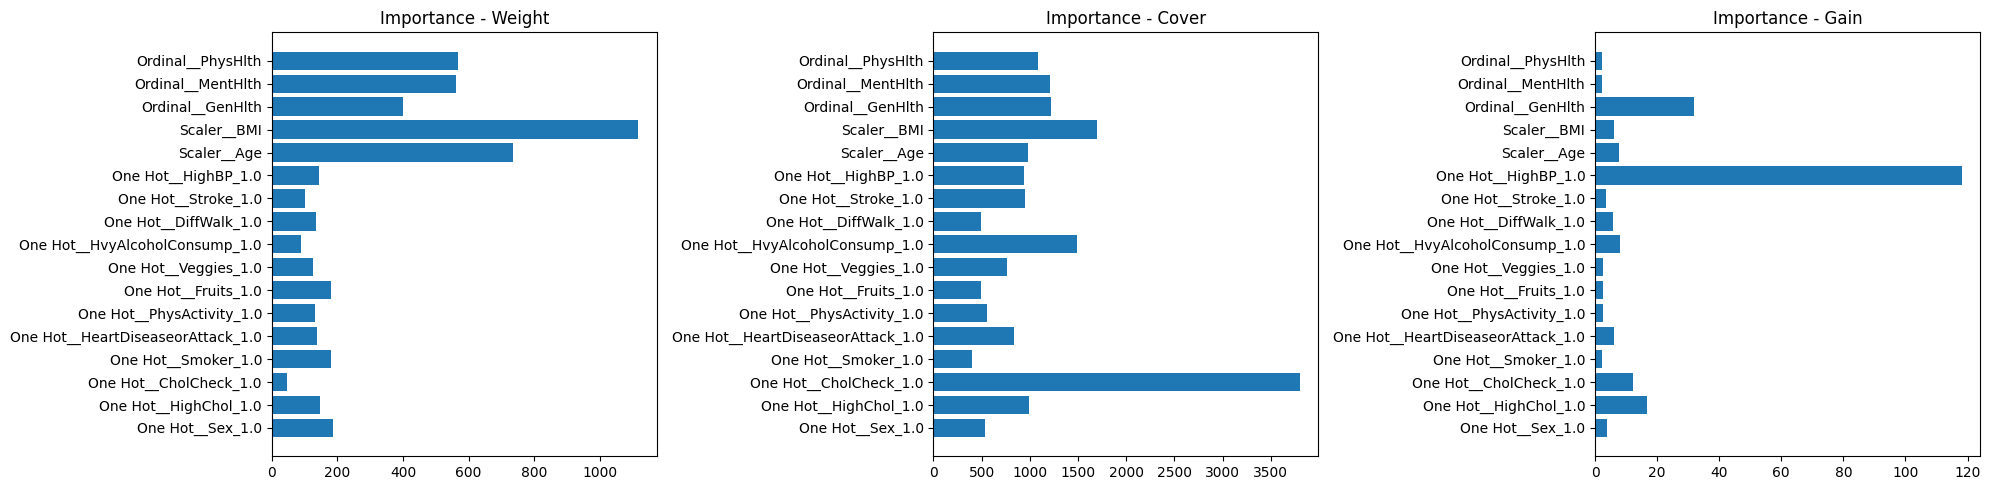

In [ ]:
# Crear una figura con 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Peso
ax[0].barh(list(mapped_importances_weight.keys()), list(mapped_importances_weight.values()))
ax[0].set_title('Importance - Weight')

# Cobertura
ax[1].barh(list(mapped_importances_cover.keys()), list(mapped_importances_cover.values()))
ax[1].set_title('Importance - Cover')

# Ganancia
ax[2].barh(list(mapped_importances_gain.keys()), list(mapped_importances_gain.values()))
ax[2].set_title('Importance - Gain')

# Ajustar el diseño y mostrar la figura con los subplots
plt.tight_layout()
plt.show()


Según los resultados obtenidos en el análisis de los métodos Weight, Gain y Cover, se identificaron diferentes variables como las más relevantes. La Variable BMI se destacó en Weight, CholCheck en Gain y HighBP en Cover. Estos hallazgos resaltan la importancia de las variables relacionadas con el historial médico de la persona, como Índice de Masa Corporal , niveles elevados de colesterol y Presión Arterial Alta. Este hallazgo resulta lógico, considerando que la diabetes es una enfermedad que impacta en todo el organismo, lo que sugiere la posible presencia de otras condiciones asociadas en quienes la padecen.


Cada uno de los métodos Weight, Gain y Cover proporciona una perspectiva diferente sobre la relevancia de las características en el modelo:


- Weight se refiere a la frecuencia con la que una característica aparece en los árboles de ensamble, una característica con un alto valor de peso simplemente significa que se ha utilizado más a menudo en los árboles del modelo.
- Gain representa la mejora promedio en la precisión que aporta una característica a los árboles, una característica con un alto valor de ganancia significa que ha contribuido a aumentar significativamente la precisión del modelo.
- Cover indica el promedio de cover de las observaciones de una característica, relacionado con el número de muestras afectadas por su división, una característica con un alto valor de cover significa que ha afectado a un gran número de muestras.


Estos métodos pueden dar importancias variadas a las características dependiendo del objetivo. Por ejemplo, una característica podría tener un alto peso (Weight) al ser utilizada con frecuencia en los árboles, pero su contribución a la mejora de las predicciones (Gain) podría ser baja. De manera similar, una característica podría tener un bajo Weight pero un alto Cover, afectando a un gran número de observaciones cuando se usa. No existe un valor específico que defina una característica como "buena" o "mala" basándose únicamente en Weight, Gain o Cover, ya que estos valores dependen de diferentes factores como la frecuencia de uso, la mejora en la precisión y la cobertura de las muestras, respectivamente.


Este metodo no esta libre de debilidades, por ejemplo, características con numerosas categorías o valores únicos pueden mostrar una importancia inflada. Además, la importancia de las características puede variar con diferentes conjuntos de entrenamiento, volviéndose inestable. A pesar de estas limitaciones, la evaluación de la importancia de las características sigue siendo útil para obtener una visión inicial de qué atributos son relevantes para el modelo.


## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

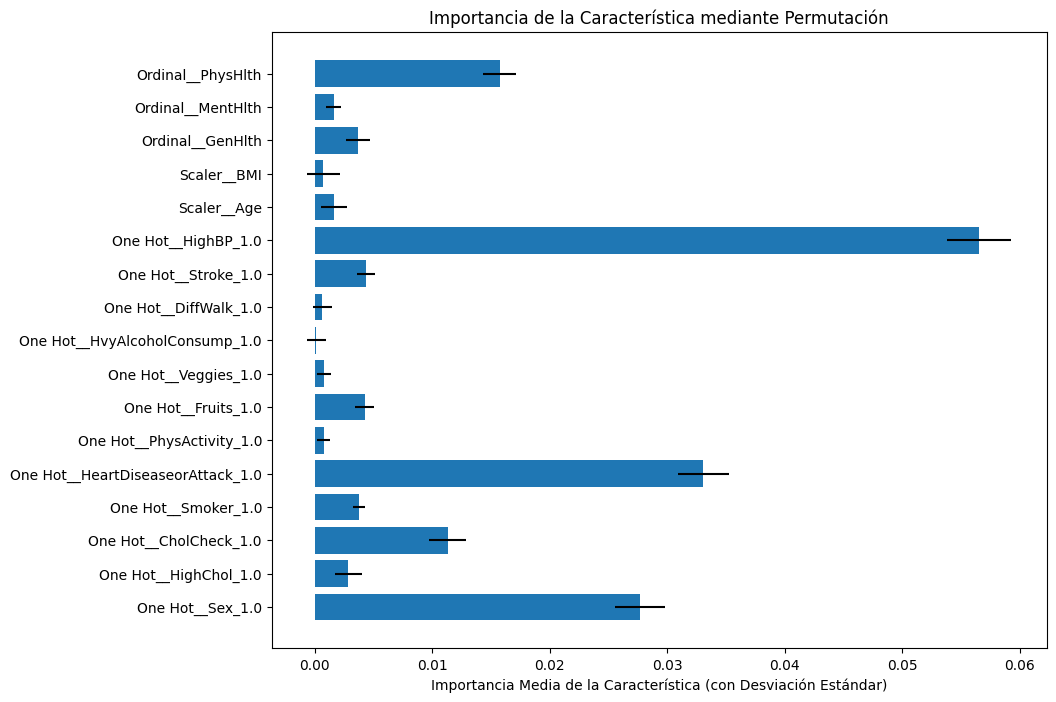

In [ ]:
# Asegurarse de tener los nombres de las características correctos
feature_names = XGBoost_clas.named_steps['preprocessing'].get_feature_names_out()

# Ejecutar el método de permutación 30 veces
results = permutation_importance(XGBoost_clas, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Obtener la importancia media y la desviación estándar
importances_mean = results.importances_mean
importances_std = results.importances_std

# Visualizar la importancia de las características
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances_mean, xerr=importances_std)
plt.xlabel('Importancia Media de la Característica (con Desviación Estándar)')
plt.title('Importancia de la Característica mediante Permutación')
plt.show()




La desviación estándar en este caso revela que la importancia de las variables no es constante. Esta variabilidad se debe al método de permutación, el cual es una técnica de aproximación y la importancia de las características puede experimentar pequeñas variaciones en cada ejecución del método.


La medición de la importancia se hace mediante el método de importancia de la permutación. Se evalúa la relevancia de una característica al permutar aleatoriamente sus valores en el conjunto de datos y cuantificar la disminución en la precisión del modelo como resultado.


Entre las 5 características con mayor impacto son: Presión Arterial Alta (HighBP), HeartDisorderAttack, Genero, Salud general (Physhlth) y (CholCheck). Estas variables son coherentes, dado que son factores de riesgo conocidos para la diabetes. Además, la salud general puede estar vinculada a la diabetes, ya que las personas afectadas por esta condición tienden a tener una salud general más delicada.


En cuanto al cambio con rspecto a antes, las características más relevantes son consistentes, aunque el orden de importancia varia. Esta variación se debe a la naturaleza aproximada del método de permutación, que provoca pequeñas alteraciones en la importancia de las características en cada ejecución del proceso.


En cuanto a ventajas:


- Interpretabilidad: Este método es altamente comprensible y fácil de explicar. Evalúa la relevancia de las características al medir la disminución en la precisión del modelo cuando los valores de una característica se permutan aleatoriamente.


- Manejo de características irrelevantes y redundantes: Este enfoque es capaz de identificar características que no aportan a la precisión del modelo. Si al permutar los valores de una característica no se afecta la precisión del modelo, es probable que dicha característica sea irrelevante.




- Generalidad: Puede ser aplicado a cualquier modelo supervisado, a diferencia de otros métodos de evaluación de importancia de características que se restringen a ciertos tipos de modelos.


En cuanto a desventajas:


- Costo computacional: La evaluación de la importancia mediante permutación puede ser costosa computacionalmente, especialmente en conjuntos de datos con numerosas características, ya que requiere reajustar el modelo para cada una de ellas.


- Correlación entre características: Si dos características están altamente correlacionadas, permutar una de ellas puede no afectar significativamente la precisión del modelo, dado que la otra característica proporciona información similar. Esto puede conducir a una subestimación de la importancia de dichas características.


- Ruido aleatorio: Al basarse en la permutación aleatoria de valores de características, este método puede ser susceptible al ruido aleatorio. Aunque repetir el proceso y obtener un promedio puede ayudar a mitigar este problema, también conlleva un aumento en el costo computacional.






## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [ ]:
!pip install shap

In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [ ]:
#Para obtener los nombres
feature_names = ct.get_feature_names_out()

#Aplicamos el procesamiento al conjunto X
X = df.drop(columns=['Diabetes'])
X_prep = pd.DataFrame(ct.transform(X), columns=feature_names)

# Crear el explainer con el conjunto
xgboost_model = XGBoost_clas.named_steps['model']
explainer = shap.TreeExplainer(xgboost_model)

# Calcular los shapley values
shap_values = explainer.shap_values(X_prep)

[04:17:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
print(shap_values)

[[-0.00460456 -0.3848604   0.02467936 ...  0.19915318 -0.22279075
   0.08616973]
 [ 0.05632673  0.14292245  0.01815863 ...  0.13971637  0.01248265
   0.02512943]
 [ 0.31258932 -0.297469    0.03093003 ... -0.9846991   0.0673209
   0.25670406]
 ...
 [-0.08597348  0.28478292  0.01470587 ...  0.86942726 -0.15803117
   0.04650539]
 [-0.1685042   0.33939835  0.02485717 ...  0.80530185  0.04959565
   0.08810985]
 [ 0.03591182  0.23616262  0.02084731 ... -0.59756786  0.09190472
   0.00486993]]


In [ ]:
# Visualizar los SHAP values para una instancia específica (en este caso la primera)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_prep.iloc[0,:])


Los valores SHAP representan la contribución específica de cada característica a la predicción de un modelo en comparación con la predicción promedio del mismo. Estos valores sirven para interpretar cómo cada característica afecta las predicciones.

Un valor SHAP positivo para una característica señala que esta aumenta la predicción del modelo para esa observación respecto a la predicción promedio. Por el contrario, un valor SHAP negativo indica que la característica reduce la predicción del modelo para esa observación.

La magnitud absoluta de los valores SHAP refleja el impacto de cada característica en la predicción. Asi que aquellas con mayores valores absolutos de SHAP se consideran más relevantes para el modelo en términos predictivos.

Los valores SHAP respetan la propiedad aditiva de los juegos cooperativos. Esto implica que la suma de los valores SHAP de todas las características es igual a la diferencia entre la predicción del modelo para una observación específica y la predicción promedio del modelo.

A diferencia de otros métodos de evaluación de la importancia de características, los valores SHAP capturan las interacciones entre las características. Esta consideración proporciona una visión más completa de la importancia relativa de las características en el modelo.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

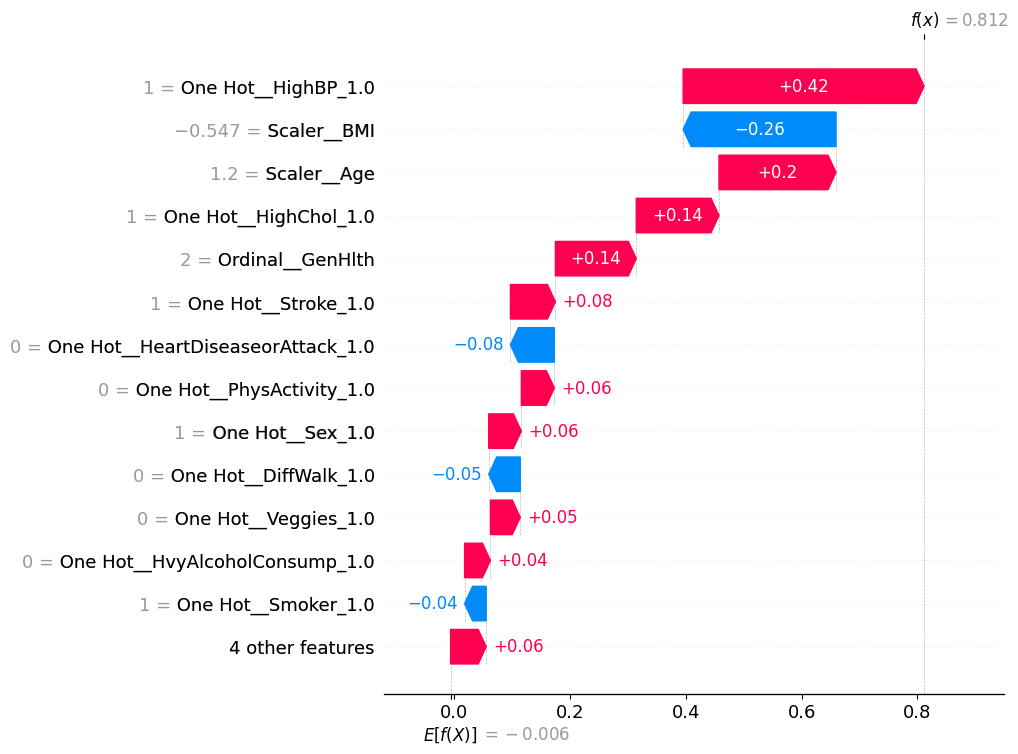

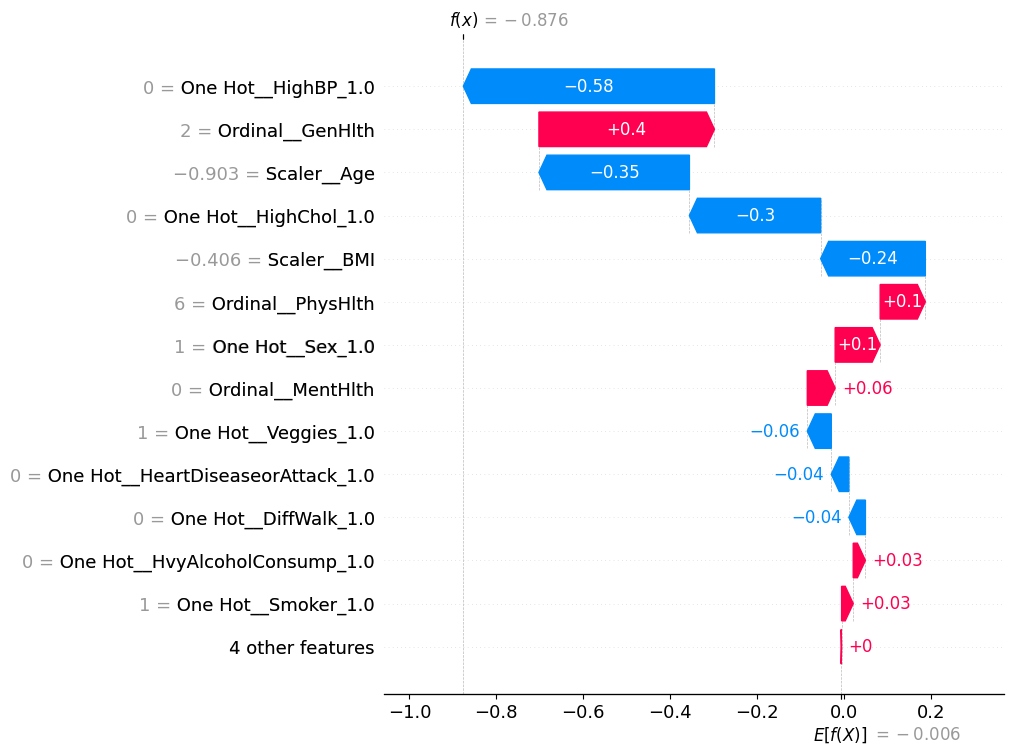

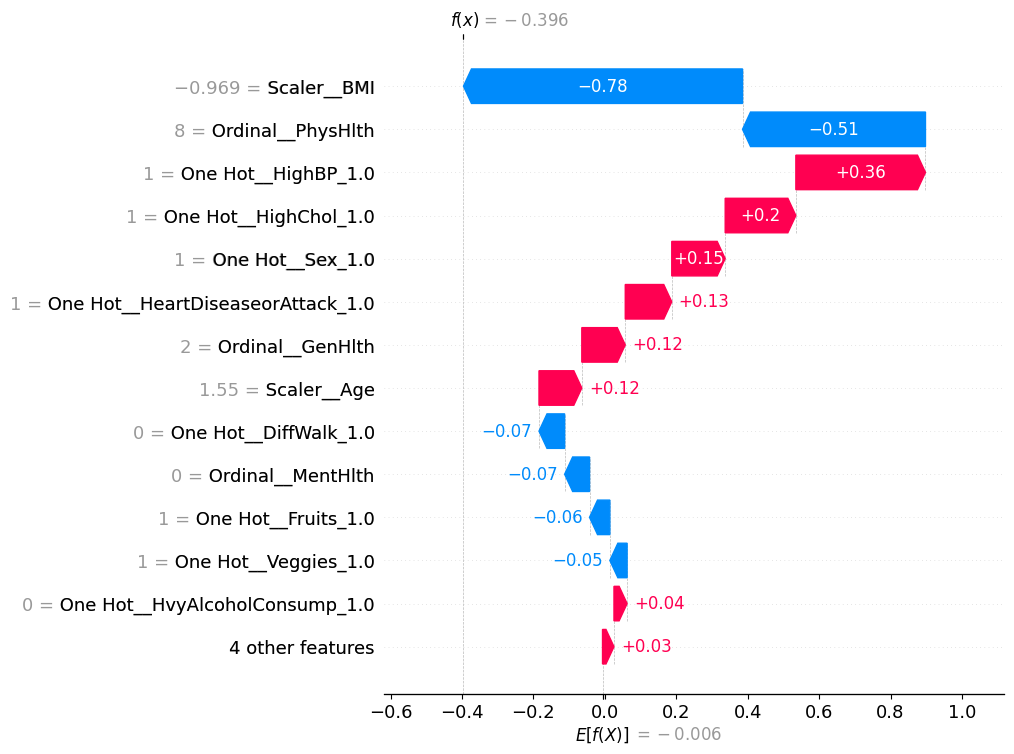

In [ ]:

shap.initjs()
shap_values_df = pd.DataFrame(shap_values, columns=feature_names)
# Obtener el aporte de las diferentes variables para las instancias 1, 9 y 150
instances = [1, 9, 150]


# Mostrar 10 features como máximo en tu gráfico waterfall
max_display_features = 10

for instance in instances:
    # Convertir los valores SHAP de la instancia actual en un objeto Explanation
    explanation = shap.Explanation(values=shap_values[instance],
                                   base_values=explainer.expected_value,
                                   data=X_prep.iloc[instance],
                                   feature_names=feature_names)

    # Generar el waterfall plot para la instancia actual
    shap.plots.waterfall(explanation, max_display=max_display_features)



#for instance in instances:
 #   shap.force.waterfall(explainer.expected_value, shap_values[instance], X_prep.iloc[instance], matplotlib=True)

Los gráficos ilustran como diferentes carácteristicas impactan en predicciones específicas. En los casos estudiados se observa que que una presión arterial alta afecta psotivamente en la predicción (mayor probabilidad de tener diabetes), mientras que si esta es baja, afecta de manera negativa. El BMI también tiene un efecto importante en la probabilidad de diabtes, en las tres instancias se observa que un valor negativo de este influye de manera negativa a la predicción. La edad también es un factor a considerar, se observa que una magnitud menor afecta de manera negativa a la predicción, mientras que cuando es mayor es al contrario. Por otra parte, el nivel de colesterol es otra variable influyente, ya que cuando el nivel de colesterol es alto (igual a 1), esta variable contribuye positivamente a la predicción.


Es importante tener en cuenta que estas 3 instancias individuales no definen un patrón general para los datos. Aunque algunas variables tienen un peso significativo, hay que ser cuidadosos al interpretar los valores SHAP, ya que representan promedios y no se aplican a cada caso particular.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

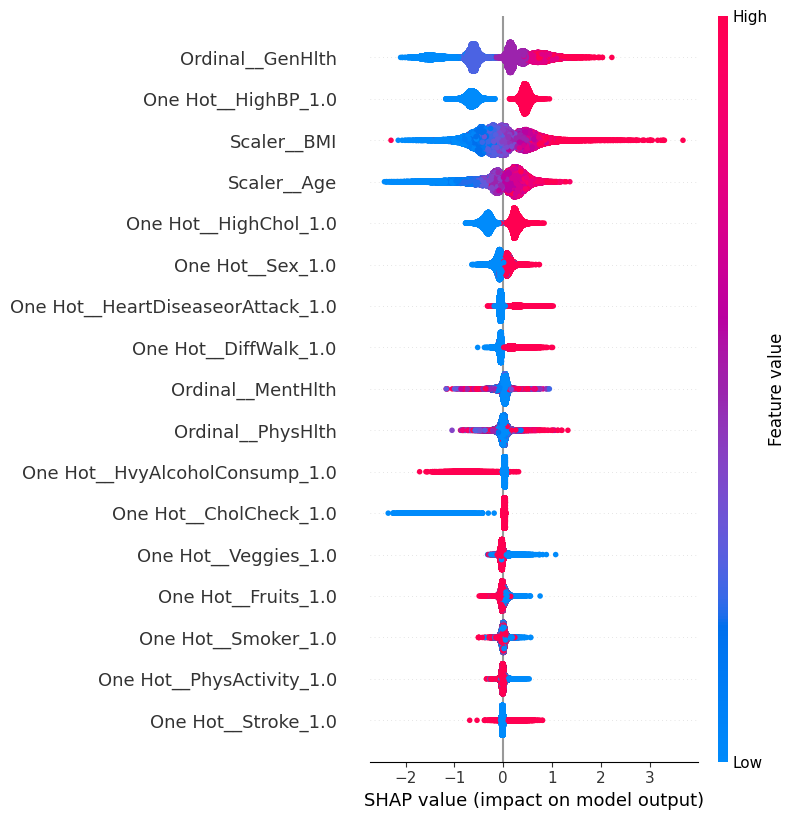

In [ ]:
shap.summary_plot(shap_values_df.values, X_prep)

Comparado con las conclusiones generadas a nivel de instancia, ahora se brinda una perspectiva más amplia sobre la importancia de las características en el conjunto de datos en su totalidad, en contraste con el enfoque en casos específicos. Esto permite identificar qué características son generalmente relevantes para el modelo, en lugar de aquellas que son importantes únicamente para casos individuales.

Entonces,  los resultados a nivel global pueden ofrecer una visión más amplia y sólida sobre la importancia de las características de manera generalizable.

En el grafico se observa que las características más relevantes son GenHlt, HighBP, BMI, Age y HighChol. Esto concuerda con los resultados a nivel de instancia, donde todas estas variables estuvieron en el top 5 de alguna de ellas.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

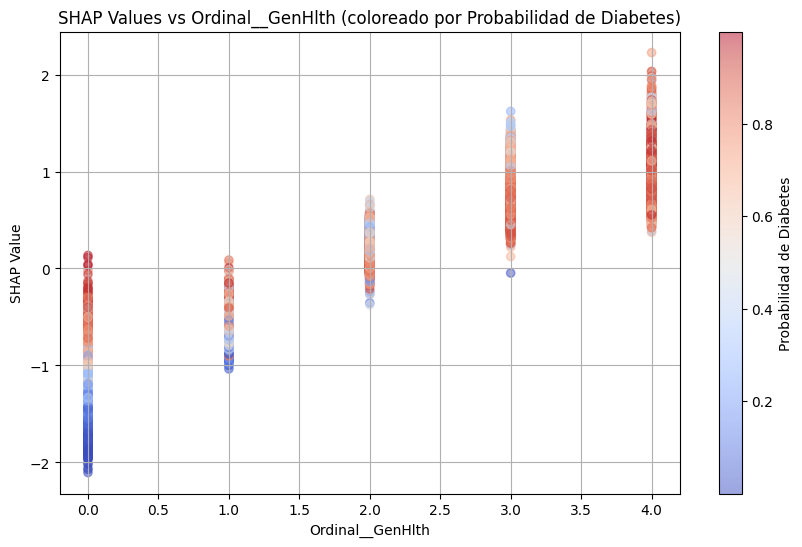

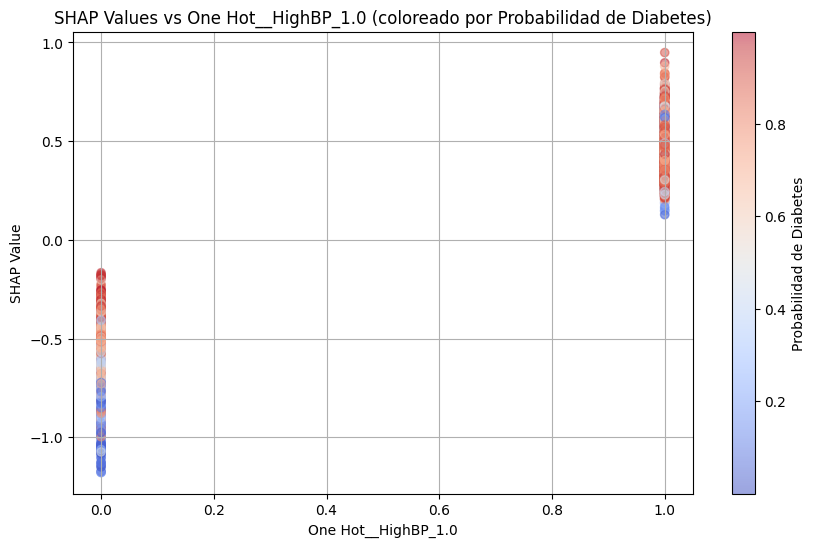

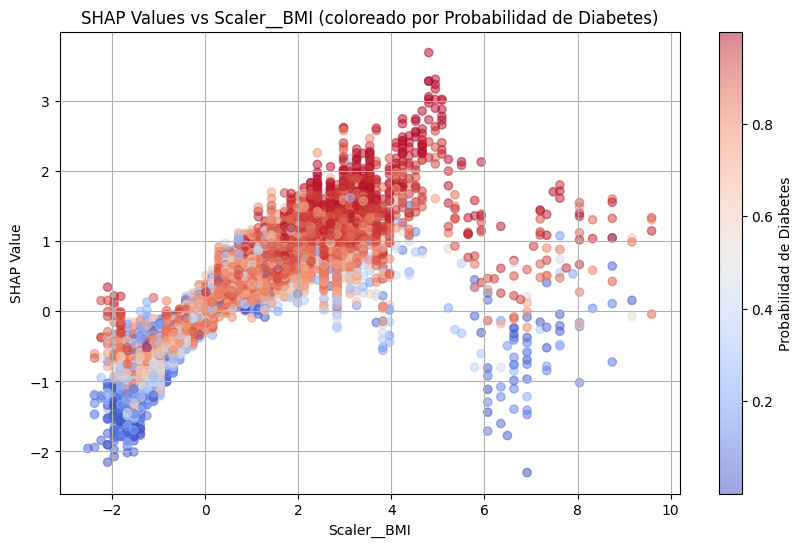

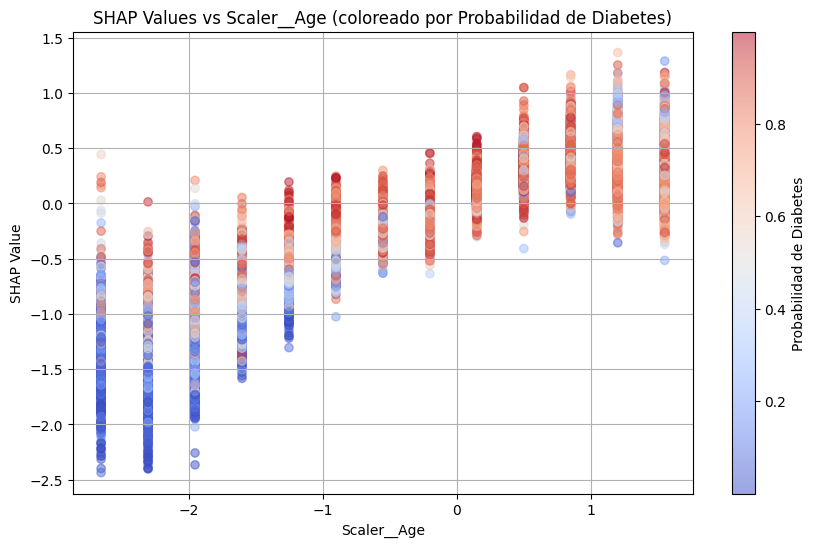

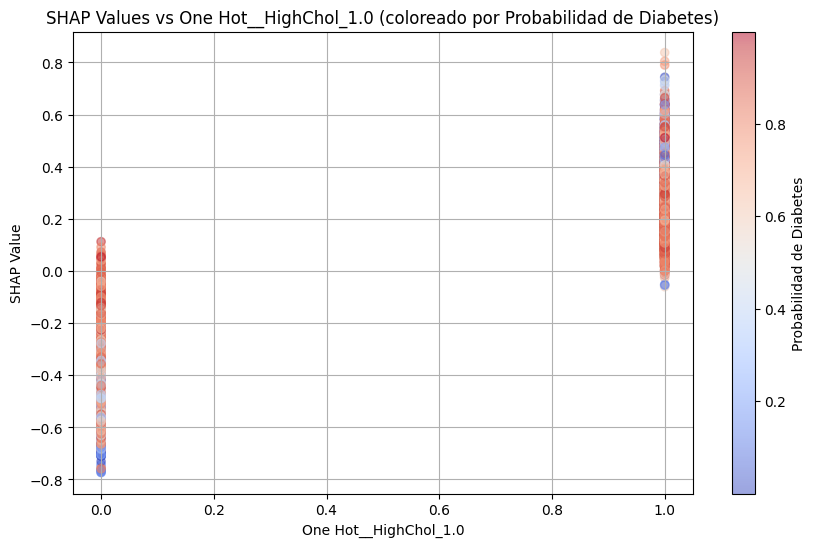

In [ ]:
# Calculamos los valores SHAP absolutos promediados
shap_values_abs_mean = np.mean(np.abs(shap_values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor importancia
feature_importance_names = X_prep.columns[np.argsort(shap_values_abs_mean)[::-1]]
#predicciones de probabilidad
probs = xgboost_model.predict_proba(X_prep)[:, 1]

# Generar gráficos de dispersión
for name in feature_importance_names[:5]:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_prep[name], shap_values[:, X_prep.columns.get_loc(name)], c=probs,alpha=0.5, cmap='coolwarm')
    plt.colorbar(label='Probabilidad de Diabetes')
    plt.xlabel(name)
    plt.ylabel('SHAP Value')
    plt.title(f'SHAP Values vs {name} (coloreado por Probabilidad de Diabetes)')
    plt.grid(True)
    plt.show()

En todos los gráficos se puede observar que a mayor shap es más probable tener diabetes (puntos mpas rojos)

- GenHlth: Hay una mezcla de probabilidades de diabetes en cada nivel, pero los niveles más altos de 'GenHlth' tienden a tener puntos más rojos, lo que indica una mayor probabilidad de diabetes.

- HighBP: Los valores SHAP negativos cuando la variable es 0 y positivos cuando es 1, sugieren que tener la presión arterial alta (valor igual a 1) es un factor de riesgo según el modelo.

- BMI:Hay una tendencia clara de que a medida que el BMI aumenta, también lo hace el valor SHAP, lo que indica un mayor riesgo de diabetes.

- Age: Hay una tendencia que a mayor edad, el rango del SHAP se acerca más a los positivos y con eso, también se ve un aumento en la probabilidad de tener diabete.

- HighChol: Los puntos con 1 (colesterol alto) tienden a tener valores SHAP positivos, lo que indica que es un factor de riesgo para la diabetes según el modelo.

En general, estos gráficos muestran que ciertas condiciones médicas (presión arterial alta, colesterol alto) y factores de riesgo (BMI, percepción de mala salud) se asocian con un mayor riesgo de diabetes según el modelo.

Estos resultados pueden ser útiles para el Dr. Simi para entender cómo el modelo hace sus predicciones y potencialmente para identificar áreas donde se podría necesitar más información o investigación.

### 5.5 Partial Dependence Plot (0.4 puntos)


Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

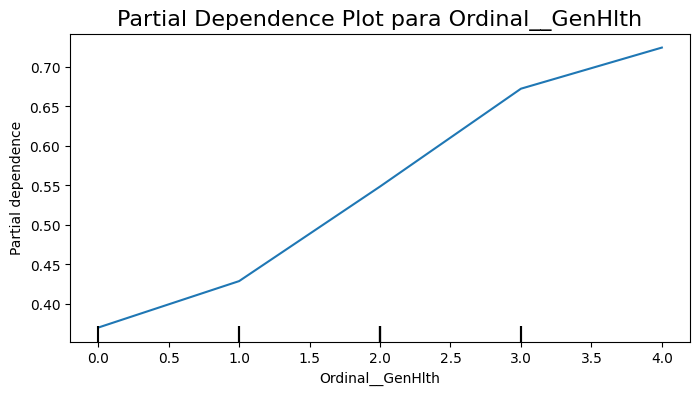

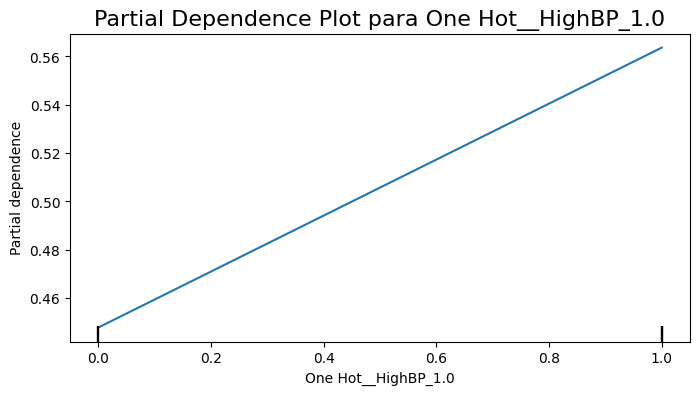

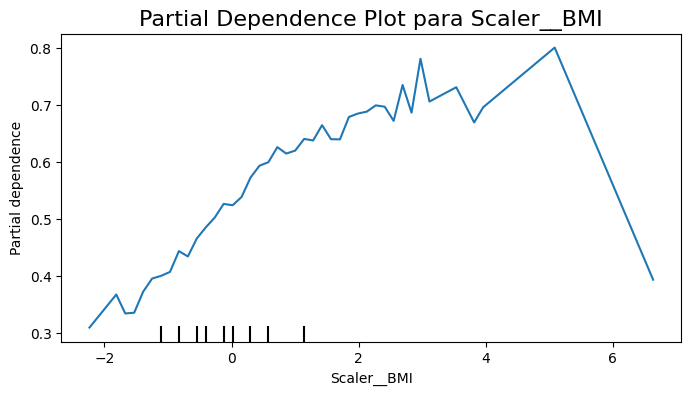

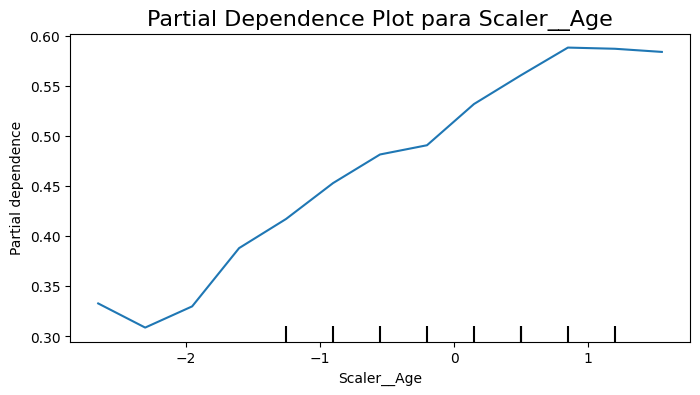

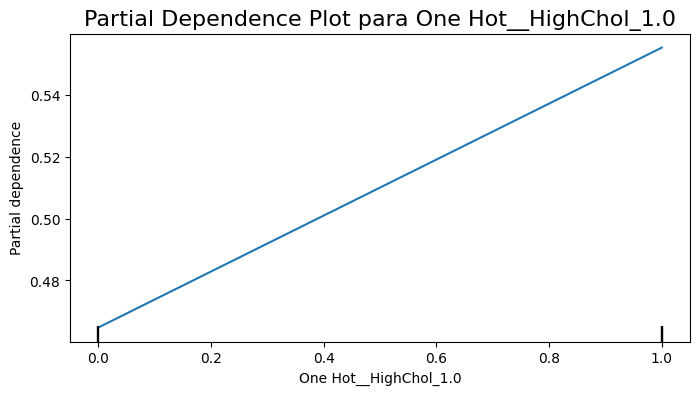

In [ ]:
# Elegimos una submuestra aleatoria de 1000 observaciones de X_test
np.random.seed(0)  # Para reproducibilidad
subsample_indices = np.random.choice(X_prep.shape[0], 1000, replace=False)
X_subsample = X_prep.iloc[subsample_indices]

# Ahora generamos los Partial Dependence Plots para las 5 características más importantes
for feature in feature_importance_names[:5]:
    fig, ax = plt.subplots(figsize=(8, 4))
    PartialDependenceDisplay.from_estimator(
        xgboost_model, X_subsample, [feature], ax=ax, grid_resolution=50, kind='average'
    )
    ax.set_title(f"Partial Dependence Plot para {feature}", fontsize=16)
    ax.set_xlabel(feature, fontsize=12, rotation=45)
    ax.set_ylabel("Predicted probability change", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

Los Partial Dependence Plots (PDP) muestran cómo la predicción promedio de un modelo cambia con diferentes valores de una característica, manteniendo todas las demás características en su valor promedio.

- GenHlth: El PDP muestra una tendencia ascendente clara, indicando que a medida que empeora la percepción de la salud general, el modelo predice una mayor probabilidad de diabetes.

- HighBP: El PDP muestra un incremento lineal, lo que significa que la presencia de presión arterial alta (valor de 1) se asocia con un aumento en la probabilidad de diabetes según el modelo.

- BMI: Aquí vemos una relación más compleja. A medida que aumenta el BMI, también lo hace la predicción promedio de la probabilidad de diabetes, pero la relación no es completamente lineal y presenta cierta variabilidad. Esto podría reflejar cómo la relación entre BMI y diabetes es más compleja y posiblemente afectada por otros factores.

- Age:  A medida que la edad aumenta, la probabilidad de diabetes también aumenta. Hacia el extremo derecho del gráfico, donde los valores estandarizados de la edad son más altos (lo que indicaría una edad más avanzada), la probabilidad se estabiliza. Esto podría sugerir que una vez que se alcanza cierta edad, el modelo no considera aumentos adicionales en la edad como un riesgo significativamente mayor.

- HighChol: Similar al PDP para la presión arterial alta, muestra un incremento lineal en la probabilidad de diabetes cuando el colesterol alto está presente (valor de 1

No se puede afirmar que las conclusiones son generalizables ya que puede que el conjunto de datos aleatorios no capture todas las variaciones dentro del conjunto de datos completo, además, las relaciones observadas en los gráficos de dependencia parcial pueden no ser causales. Los PDP asumen que las características son independientes entre sí, lo que rara vez ocurre en los datos reales. Las interacciones entre características pueden influir en las predicciones de maneras que los PDP no pueden capturar.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

In [ ]:
from alibi.explainers import AnchorTabular

In [ ]:
def predict_fn(input_data):
    return xgboost_model.predict(input_data)

explainer = AnchorTabular(predict_fn, feature_names, seed=1)
explainer.fit(X_train.to_numpy())


#indices a procesar
idx_values = [1000, 3001, 5751]

class_names = ["Sin Diabetes", "Con Diabetes"]

for idx in idx_values:
    print(f"\nExplanation for instance at index {idx}:")
    print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
    explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
    print('Anchor: %s' % (' AND '.join(explanation.anchor)))
    print('Precision: %.2f' % explanation.precision)
    print('Coverage: %.2f' % explanation.coverage)



Explanation for instance at index 1000:
Prediction:  Con Diabetes
Anchor: One Hot__CholCheck_1.0 > 0.00
Precision: 0.99
Coverage: 0.52

Explanation for instance at index 3001:
Prediction:  Con Diabetes
Anchor: One Hot__HighChol_1.0 > 0.00 AND Ordinal__PhysHlth > 0.00 AND Scaler__Age > 2.00 AND One Hot__PhysActivity_1.0 > 0.00 AND One Hot__HeartDiseaseorAttack_1.0 > 29.00
Precision: 0.97
Coverage: 0.02

Explanation for instance at index 5751:
Prediction:  Con Diabetes
Anchor: One Hot__CholCheck_1.0 > 0.00 AND One Hot__HighChol_1.0 > 0.00
Precision: 0.99
Coverage: 0.24


Estas reglas muestran una precisión notable, lo que indica que son predictivas en un alto porcentaje, ya sea para predecir la presencia o ausencia de diabetes en un individuo.


La primera regla de predicción para el individuo de índice 1000 indica que la condición principal para predecir la presencia de diabetes es la detección positiva de la variable "CholCheck" ("One Hot__CholCheck_1.0 > 0.00"). Esta única condición tiene una alta precisión del 99%, lo que significa que en el 99% de los casos en que se encuentra esta condición, la predicción de diabetes es acertada. Además, esta regla se aplica al 52% de la muestra total, lo que indica que una cantidad considerable de casos dentro de la muestra comparten esta condición específica de que la detección positiva de "CholCheck" es un indicador relevante para la presencia de diabetes.


La segunda regla establece que, para predecir la presencia de diabetes en un individuo específico (índice 3001), se requiere la conjunción de múltiples condiciones: altos niveles de colesterol, salud física subóptima, edad escalada mayor que 2, alta actividad física y antecedentes de enfermedad cardíaca o ataques cardíacos. Esta combinación particular tiene una precisión del 97%, lo que significa que en el 97% de los casos en que se cumplen estas condiciones, la predicción es acertada. Aun asi, esta regla solo se aplica al 0.02% de la muestra.


La tercera regla para predecir la presencia de diabetes en el individuo de índice 5751 se basa en la presencia de dos condiciones específicas: la detección positiva de colesterol ("One Hot__CholCheck_1.0 > 0.00") y la existencia de niveles altos de colesterol ("One Hot__HighChol_1.0 > 0.00"). Esta combinación de condiciones tiene una alta precisión del 99%, lo que significa que en el 99% de los casos en que estas condiciones se cumplen simultáneamente, la predicción de diabetes es correcta. Sin embargo, esta regla se aplica a aproximadamente el 24% de la muestra total, lo que indica que es un patrón más común pero aún selectivo dentro del conjunto de datos analizados.


A pesar de que estas reglas no abarcan un porcentaje muy alto del conjunto de datos para la predicción con diabetes (7%), son relevantes en una variedad decente de situaciones, lo que las convierte en herramientas valiosas para interpretar las predicciones del modelo en diferentes escenarios. A pesar de no cubrir todos los casos, su alta precisión en los segmentos de población que abarcan las hace útiles y confiables para la interpretación del modelo.




# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Dependiendo de la perspectiva que busquemos, cada método tiene sus puntos fuertes y limitaciones.

La Importancia de las Características es un método global que ofrece una panorámica sobre qué rasgos son más relevantes para el modelo en su conjunto. Resulta útil para obtener una comprensión general de los aspectos considerados por el modelo al tomar decisiones, pero no revela cómo esas características influyen individualmente en cada predicción.

El método SHAP (SHapley Additive exPlanations) constituye tanto un enfoque local como global. A nivel local, proporciona una explicación detallada de cómo cada característica contribuye a la predicción para una instancia individual, lo cual es valioso para comprender el razonamiento del modelo en casos específicos. A nivel global, brinda una visión general de cómo las características influyen en las predicciones del modelo en general. Los gráficos de dependencia de SHAP y las representaciones de la importancia de las características ofrecen una visión detallada y completa de las decisiones del modelo.

Por otro lado, las Anchor Rules constituyen un método local que ofrece reglas claras y fácilmente interpretables que explican por qué el modelo realizó una predicción específica. Esto resulta especialmente útil para proporcionar explicaciones simples y comprensibles a personas no expertas en el modelo, como los pacientes en este caso.

Los gráficos de dependencia parcial (Partial Dependence Plots, PDP) ofrecen un enfoque más global y son útiles para entender cómo los diferentes niveles de una característica en particular afectan la salida promedio del modelo.

En la tarea de clasificación de la diabetes, tanto SHAP como las Reglas de Anclaje ofrecen conclusiones detalladas y útiles. SHAP proporciona una visión minuciosa de cómo las características afectan las predicciones tanto a nivel individual como general, mientras que las Reglas de Anclaje ofrecen explicaciones simples y comprensibles para las predicciones individuales.

Respecto a la consulta del Dr. Simi, la elección del método depende del propósito de la explicación. Si el Dr. Simi necesita entender las decisiones del modelo de manera general para mejorar el modelo o para verificar su coherencia con el entendimiento médico de la diabetes, los métodos globales como la Importancia de las Características, PDP y SHAP a nivel global serían más útiles. Por otro lado, si el Dr. Simi necesita explicar a un paciente en particular por qué el modelo realizó una predicción específica, entonces los métodos locales como SHAP a nivel individual y las Reglas de Anclaje serían más apropiados, dado que se optimizan las decisiones y predicciones para cada grupo, determinando si tienen diabetes o no. La capacidad de comprender el razonamiento detrás de una predicción puede ayudar a los pacientes a confiar más en el diagnóstico o pronóstico, lo cual es especialmente relevante en el ámbito médico, donde la confianza del paciente puede influir en su abordaje frente a la enfermedad.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>